In [1]:
# Reddit API
import praw

# Data Processing
import pandas as pd
import numpy as np
import re

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# Part1: Data Acquisition

In [2]:
# Reddit API Credentials
reddit = praw.Reddit(
    client_id="_9aT35rxVcBiNC17_Al5_g",
    client_secret="tyas9JGsMfhm4Jhifg86JnvpHZHx6A",
    user_agent="CryptoSentimentApp"
)

def fetch_reddit_posts(coin, num_posts):
    """
    Fetches Reddit posts related to a cryptocurrency and returns data in a Pandas DataFrame.
    
    Parameters:
    - coin (str): The cryptocurrency to search for.
    - num_posts (int): Number of posts to retrieve.

    Returns:
    - pd.DataFrame: DataFrame containing post details.
    """
    subreddit = reddit.subreddit("cryptocurrency")
    query = coin.lower()  
    
    
    posts_data = []
    for post in subreddit.search(query, limit=num_posts):
        posts_data.append([
            post.id,
            post.title,
            post.selftext,  # Post content
            post.score,  # Upvotes
            post.num_comments,  # Number of comments
            post.url,  # Post link
            post.created_utc  # Timestamp
        ])

    
    df = pd.DataFrame(posts_data, columns=["Post_ID", "Title", "Content", "Upvotes", "Comments", "URL", "Timestamp"])
    return df

df_bitcoin_1000 = fetch_reddit_posts("Bitcoin", 1000)
print(df_bitcoin_1000.head())
print(df_bitcoin_1000.shape)

df_bitcoin_1000.to_csv('csv_bitcoin_1000.csv', index = False) # Ensure there is no index column

   Post_ID                                              Title  \
0  1gqafju  Bitcoin has followed a consistent 4-year cycle...   
1  1iq3fe9         Me In 2009 Instead of Buying Bitcoin (BTC)   
2  1h6yoqp  On February 9th 2011 Bitcoin first touched $1....   
3  1ik2qgu  Explaining Bitcoin 12 Years Ago When It Was Wo...   
4  1hbsf6a  This Anonymous guy received $50 worth of Bitco...   

                        Content  Upvotes  Comments  \
0                                   3577       701   
1                                  19972       342   
2                                   7834       495   
3                                   8419       293   
4  Imagine hodling for 13 Years     7422       452   

                                    URL     Timestamp  
0  https://i.redd.it/95px1ns8in0e1.jpeg  1.731496e+09  
1   https://i.redd.it/denbcysakbje1.png  1.739632e+09  
2   https://i.redd.it/m7ll0go40y4e1.png  1.733366e+09  
3   https://i.redd.it/hd0ul5cglrhe1.png  1.738955e+09  
4  h

# Part2: Data Cleaning

In [3]:
def clean_reddit_data(df):
    """
    Cleans Reddit dataset by fixing inconsistencies, formatting text, and removing duplicates.
    
    Parameters:
    - df (pd.DataFrame): Raw Reddit dataset
    
    Returns:
    - pd.DataFrame: Cleaned dataset
    """
    
    # Fix Data Inconsistencies (Convert Timestamp, Standardize Column Names)
    df = df.copy()
    df.columns = df.columns.str.lower().str.replace(" ", "_")  # Standardize column names
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")  # Convert UNIX timestamp to datetime
    
    # Uniform Formatting (Lowercasing & Removing Special Characters)
    def clean_text(text):
        if isinstance(text, str):
            text = text.lower()  # Convert to lowercase
            text = re.sub(r"http\S+", "", text)  # Remove URLs
            text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove special characters
            text = text.strip()  # Remove leading/trailing spaces
        return text

    df["title"] = df["title"].apply(clean_text)
    df["content"] = df["content"].apply(clean_text)
    
    # Remove Duplicates
    df.drop_duplicates(subset=["url"], inplace=True)  # Remove duplicate URLs
    df.drop(columns=[col for col in df.columns if "unnamed" in col], errors="ignore", inplace=True)
    df["content"].fillna("No content", inplace=True)
    df["content"] = df["content"].replace("", "No content") # There is one content is " "
    return df

df_bitcoin_1000 = pd.read_csv('csv_bitcoin_1000.csv')  # Load the dataset
df_clean_bitcoin_1000 = clean_reddit_data(df_bitcoin_1000)  # Clean the dataset
print(df_clean_bitcoin_1000.head())  # Display cleaned data
print(df_bitcoin_1000.shape)

df_clean_bitcoin_1000.to_csv('csv_clean_bitcoin_1000.csv', index = False) # Ensure there is no index column


   post_id                                              title  \
0  1gqafju  bitcoin has followed a consistent 4year cycle ...   
1  1iq3fe9           me in 2009 instead of buying bitcoin btc   
2  1h6yoqp  on february 9th 2011 bitcoin first touched 1 l...   
3  1ik2qgu  explaining bitcoin 12 years ago when it was wo...   
4  1hbsf6a  this anonymous guy received 50 worth of bitcoi...   

                        content  upvotes  comments  \
0                    No content     3577       701   
1                    No content    19972       342   
2                    No content     7834       495   
3                    No content     8419       293   
4  imagine hodling for 13 years     7422       452   

                                    url           timestamp  
0  https://i.redd.it/95px1ns8in0e1.jpeg 2024-11-13 11:04:46  
1   https://i.redd.it/denbcysakbje1.png 2025-02-15 15:13:54  
2   https://i.redd.it/m7ll0go40y4e1.png 2024-12-05 02:39:33  
3   https://i.redd.it/hd0ul5cglrhe1.

C:\Users\wbliu\AppData\Local\Temp\ipykernel_35300\2465219604.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["content"].fillna("No content", inplace=True)


# Part3: EDA

🔹 Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   post_id    235 non-null    object
 1   title      235 non-null    object
 2   content    235 non-null    object
 3   upvotes    235 non-null    int64 
 4   comments   235 non-null    int64 
 5   url        235 non-null    object
 6   timestamp  235 non-null    object
dtypes: int64(2), object(5)
memory usage: 13.0+ KB
None

🔹 Descriptive Statistics:
            upvotes     comments
count    235.000000   235.000000
mean    4873.029787   742.029787
std     5208.482462   733.526405
min      432.000000    88.000000
25%     1367.500000   272.000000
50%     3061.000000   531.000000
75%     6187.500000   979.000000
max    38849.000000  6095.000000


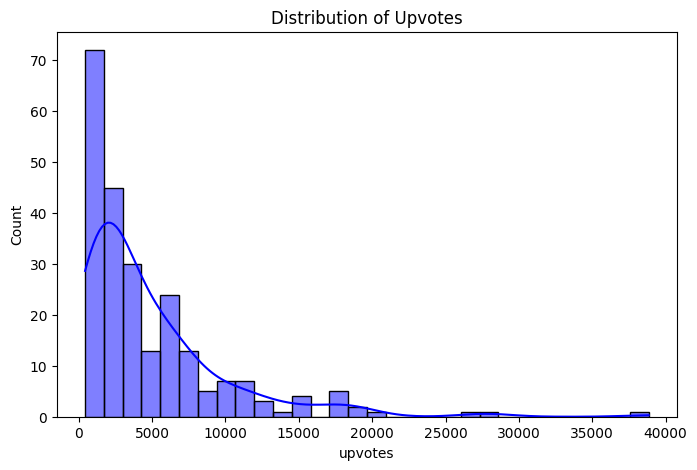

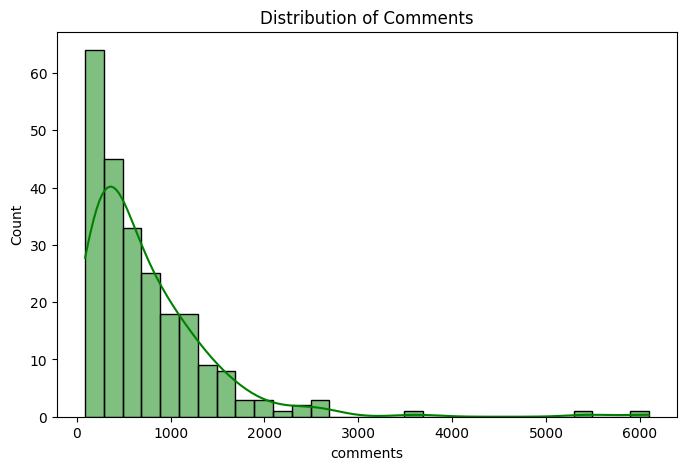

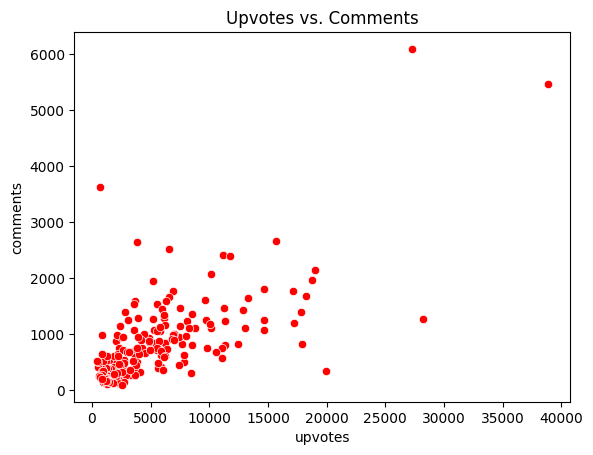

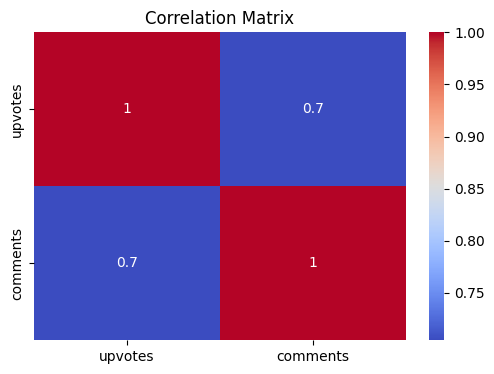

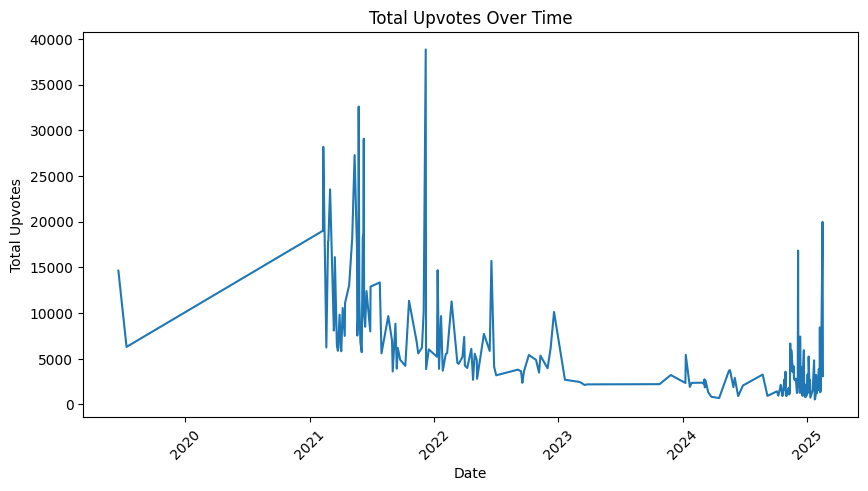


🔹 Initial Insights:
- upvotes and comments are both right-skewed distribution.
- Most posts have low upvotes, but some viral posts get extreme engagement.
- Comment count and upvotes seem to have a positive correlation.
- Distribution plots indicate possible outliers in high upvotes/comments.
- The Upvotes focused on the two years 2021 and 2025. People may more focus on Crypto in this 2 years


In [4]:
#load cleaned dataset
df_clean_bitcoin_1000 = pd.read_csv('csv_clean_bitcoin_1000.csv') 


# Exploratory Data Analysis (EDA)
def perform_eda(df):
    """
    Performs exploratory data analysis (EDA) on a cleaned Reddit dataset.
    
    Parameters:
    - df (pd.DataFrame): Cleaned dataset

    Returns:
    - None (Displays graphs and prints insights)
    """
     # Summary Statistics
    print("🔹 Dataset Overview:")
    print(df.info())
    print("\n🔹 Descriptive Statistics:")
    print(df.describe())

    # Distribution of Upvotes
    plt.figure(figsize=(8, 5))
    sns.histplot(df['upvotes'], bins=30, kde=True, color='blue')
    plt.title("Distribution of Upvotes")
    plt.show()

    # Distribution of Comments
    plt.figure(figsize=(8, 5))
    sns.histplot(df['comments'], bins=30, kde=True, color='green')
    plt.title("Distribution of Comments")
    plt.show()

    # Scatterplot
    sns.scatterplot(x='upvotes', y='comments', data=df, color='red')
    plt.title("Upvotes vs. Comments")
    plt.show()

    # Correlation Heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
    plt.title("Correlation Matrix")
    plt.show()

    # Time-based Analysis
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df.groupby('date')['upvotes'].sum().plot(figsize=(10, 5))
    plt.title("Total Upvotes Over Time")
    plt.xlabel("Date")
    plt.ylabel("Total Upvotes")
    plt.xticks(rotation=45)
    plt.show()

    # Interpretation of Findings
    print("\n🔹 Initial Insights:")
    print("- upvotes and comments are both right-skewed distribution.")
    print("- Most posts have low upvotes, but some viral posts get extreme engagement.")
    print("- Comment count and upvotes seem to have a positive correlation.")
    print("- Distribution plots indicate possible outliers in high upvotes/comments.")
    print("- The Upvotes focused on the two years 2021 and 2025. People may more focus on Crypto in this 2 years")

perform_eda(df_clean_bitcoin_1000)

# Part4: Data Preprocessing

In [7]:
def preprocess_data(df):
    """
    Performs some data pre-processing with feature transformation, and scaling.
    
    Parameters:
    - df (pd.DataFrame): Cleaned dataset

    Returns:
    - None (Displays head of data)
    """
    print("🔹 Data Preprocessing:")
    

    # Get time-based features
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['hour_of_day'] = df['timestamp'].dt.hour
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    

    # Perform feature scaling
    df['log_upvotes'] = np.log1p(df['upvotes']) 
    df['log_comments'] = np.log1p(df['comments'])
    scaler = StandardScaler()
    df[['upvotes', 'comments']] = scaler.fit_transform(df[['upvotes', 'comments']])

    # Encode the categorical title feature
    df['title_encoded'] = df['post_id'].astype('category').cat.codes

    # Filter the extreme outliers
    df = df[df['upvotes'] < df['upvotes'].quantile(0.99)]
  
    return df


df_clean_bitcoin_1000 = preprocess_data(df_clean_bitcoin_1000)
print("🔹 Preprocessing Complete. Data Sample:")
print(df_clean_bitcoin_1000.head(5))
print(df_clean_bitcoin_1000.shape)

🔹 Data Preprocessing:
🔹 Preprocessing Complete. Data Sample:
   post_id                                              title  \
0  1gqafju  bitcoin has followed a consistent 4year cycle ...   
2  1h6yoqp  on february 9th 2011 bitcoin first touched 1 l...   
3  1ik2qgu  explaining bitcoin 12 years ago when it was wo...   
4  1hbsf6a  this anonymous guy received 50 worth of bitcoi...   
5  1gs7eb9  satoshi era bitcoin whale moved 2000 btc for t...   

                        content   upvotes  comments  \
0                    No content -0.226013  0.008224   
2                    No content  0.784131 -0.356041   
3                    No content  0.922946 -0.713232   
4  imagine hodling for 13 years  0.686368 -0.432076   
5                    No content  0.335653 -0.157994   

                                    url           timestamp        date  \
0  https://i.redd.it/95px1ns8in0e1.jpeg 2024-11-13 11:04:46  2024-11-13   
2   https://i.redd.it/m7ll0go40y4e1.png 2024-12-05 02:39:33  2024-1

# Part5: Feature Engineering

🔹 Feature Engineering:


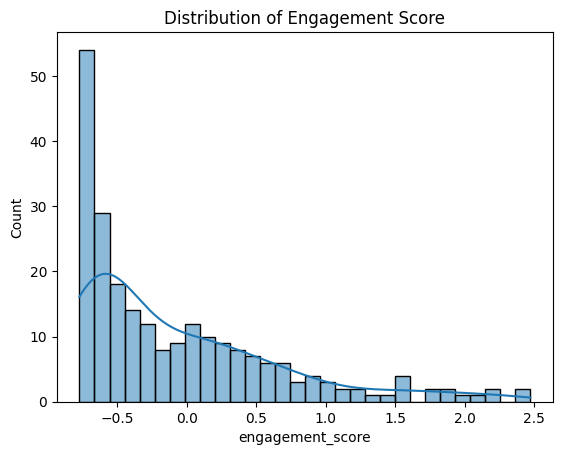

C:\Users\wbliu\AppData\Local\Temp\ipykernel_35300\400555910.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['day_of_week'], y=df['engagement_score'], palette="coolwarm")


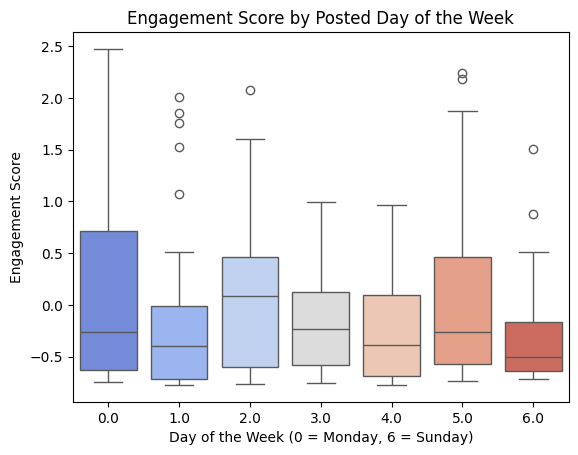

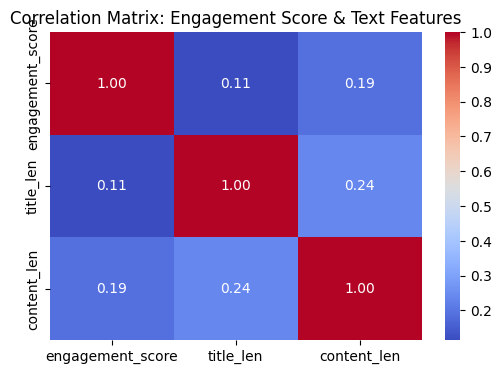

Feature engineering completed.
   post_id                                              title  \
0  1gqafju  bitcoin has followed a consistent 4year cycle ...   
1  1iq3fe9           me in 2009 instead of buying bitcoin btc   
2  1h6yoqp  on february 9th 2011 bitcoin first touched 1 l...   
3  1ik2qgu  explaining bitcoin 12 years ago when it was wo...   
4  1hbsf6a  this anonymous guy received 50 worth of bitcoi...   

                        content   upvotes  comments  \
0                    No content -0.249362 -0.056054   
1                    No content  2.905107 -0.546516   
2                    No content  0.569703 -0.337489   
3                    No content  0.682260 -0.613459   
4  imagine hodling for 13 years  0.490433 -0.396235   

                                    url           timestamp        date  \
0  https://i.redd.it/95px1ns8in0e1.jpeg 2024-11-13 11:04:46  2024-11-13   
1   https://i.redd.it/denbcysakbje1.png 2025-02-15 15:13:54  2025-02-15   
2   https://i.redd.it/

In [6]:
def feature_engineering(df):
    print("🔹 Feature Engineering:")

    df['is_working_hours'] = df['hour_of_day'].apply(lambda x: 1 if 9 <= x <= 17 else 0)
    df['title_len'] = df['title'].apply(lambda x: len(str(x).split()))
    df['content_len'] = df['content'].apply(lambda x: len(str(x).split()))
    df['engagement_score'] = df['upvotes'] * 0.7 + df['comments'] * 0.3
    df['upvote_to_comment_ratio'] = df['upvotes'] / (df['comments'] + 1)
    df['has_bitcoin'] = df['title'].apply(lambda x: 1 if 'bitcoin' in str(x).lower() else 0)

    # TF-IDF Vectorization for title
    vectorizer = TfidfVectorizer(max_features=100)
    tfidf_matrix = vectorizer.fit_transform(df['title'].astype(str))
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    df = pd.concat([df, tfidf_df], axis=1)

    df.to_csv('csv_feature_engineered_bitcoin_1000.csv', index=False)

    #Below include additional plots using the new features from above.  These show some insight into how these features could be used for further analysis
    # Plot distribution of engagement score
    sns.histplot(df['engagement_score'], bins=30, kde=True)
    plt.title("Distribution of Engagement Score")
    plt.show()

    #Engagement by week posted
    sns.boxplot(x=df['day_of_week'], y=df['engagement_score'], palette="coolwarm")
    plt.title("Engagement Score by Posted Day of the Week")
    plt.xlabel("Day of the Week (0 = Monday, 6 = Sunday)")
    plt.ylabel("Engagement Score")
    plt.show()

    # Correlation Heatmap for Engagement Score & Text Features
    plt.figure(figsize=(6, 4))
    sns.heatmap(df[["engagement_score", "title_len", "content_len"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Matrix: Engagement Score & Text Features")
    plt.show()
    
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df["date"] = df["timestamp"].dt.date

    

    print("Feature engineering completed.")
    print(df.head())



feature_engineering(df_clean_bitcoin_1000)
   